<a href="https://colab.research.google.com/github/SushmithaUW/641-Assignments/blob/master/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip fnc-1.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip


In [0]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [0]:
import gensim
import keras
import numpy as np
import pandas as pd
import pickle


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder



np.random.seed(1003)

### Python 3.6.1

### Specify Hyperparameters

In [0]:
# Specify the folder locations
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = 'fnc-1/'
Glove = 'glove.6B.200d.txt'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 200
EMBEDDING_DIM = 300
BATCH_SIZE = 200
N_EPOCHS = 10


### Load Data

In [0]:
# Read the text files of positive and negative sentences
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

competetion_unlabeled = pd.read_csv(DATA_DIR+'competition_test_stances_unlabeled.csv')








In [0]:
print('Number of Body sentences:', len(train_bodies['articleBody']))
print('Number of Headlines sentences:', len(train_stances['Headline']))

train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')
comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')


In [0]:
train.replace('unrelated',1,True)
train.replace('agree',2,True)
train.replace('disagree',3,True)
train.replace('discuss',4,True)

comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

In [136]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]

print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_headline_train], 90))
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_bodies_train], 90))

print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_headline_test], 90))
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_bodies_test], 90))

90th Percentile Sentence Length: 16.0
90th Percentile Sentence Length: 683.0
90th Percentile Sentence Length: 16.0
90th Percentile Sentence Length: 657.0


In [0]:
word_seq = []
for i in range(len(word_seq_headline_train)):
  word_seq.append(word_seq_headline_train[i])
  
for i in range(len(word_seq_bodies_train)):
  word_seq.append(word_seq_bodies_train[i])

for i in range(len(word_seq_headline_test)):
  word_seq.append(word_seq_headline_test[i])

for i in range(len(word_seq_bodies_test)):
  word_seq.append(word_seq_bodies_test[i])
  
for i in range(len(word_seq_bodies_comp)):
  word_seq.append(word_seq_bodies_comp[i])
 


In [0]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])

  
for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])
  

for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])




In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

In [0]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values

print (X_train.shape)
print (y_train.shape)


X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values



In [0]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_comp = np_utils.to_categorical(encoded_comp)


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)

In [172]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)




/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [173]:
glove2word2vec(glove_input_file=Glove, word2vec_output_file="gensim_glove_vectors.txt")
embeddings = gensim.models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [174]:
print('Number of words in this pre-trained w2v model:', len(embeddings.vocab))
print('Dimension of w2v:', embeddings.vector_size)

Number of words in this pre-trained w2v model: 400000
Dimension of w2v: 200


In [0]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

### Keras Sequential API

In [0]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))
model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))
#model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model.add(Dense(4, activation='softmax', name='output_layer'))


In [178]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 200)         4476200   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               168448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 516       
Total params: 4,645,164
Trainable params: 4,645,164
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [180]:
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_val, y_val))



Train on 44974 samples, validate on 4998 samples
Epoch 1/10
44974/44974 [==============================] - 52s 1ms/step - loss: 0.8196 - acc: 0.7255 - val_loss: 0.7223 - val_acc: 0.7407
Epoch 2/10
44974/44974 [==============================] - 50s 1ms/step - loss: 0.6631 - acc: 0.7647 - val_loss: 0.6095 - val_acc: 0.7837
Epoch 3/10
44974/44974 [==============================] - 50s 1ms/step - loss: 0.6004 - acc: 0.7934 - val_loss: 0.5931 - val_acc: 0.7905
Epoch 4/10
44974/44974 [==============================] - 51s 1ms/step - loss: 0.5581 - acc: 0.8013 - val_loss: 0.5524 - val_acc: 0.7991
Epoch 5/10
44974/44974 [==============================] - 51s 1ms/step - loss: 0.5277 - acc: 0.8064 - val_loss: 0.5411 - val_acc: 0.7985
Epoch 6/10
44974/44974 [==============================] - 51s 1ms/step - loss: 0.5180 - acc: 0.8087 - val_loss: 0.5473 - val_acc: 0.7981
Epoch 7/10
44974/44974 [==============================] - 51s 1ms/step - loss: 0.5112 - acc: 0.8123 - val_loss: 0.5450 - val_acc:

In [0]:
with open('LSTM+Glove', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

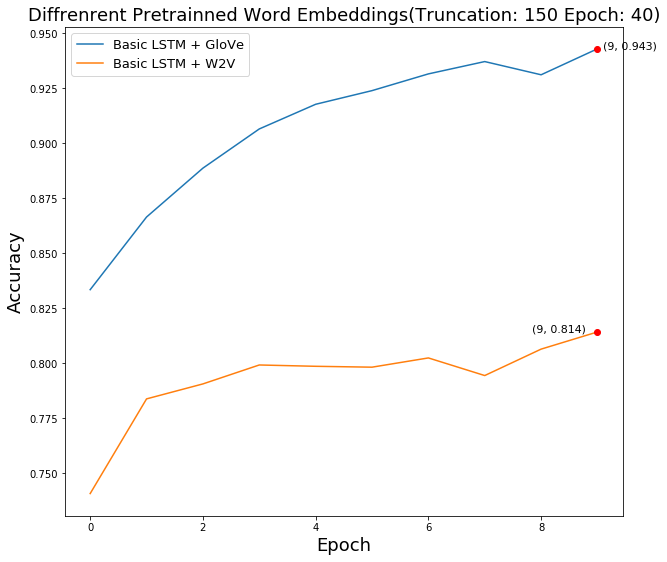

In [182]:
file1 = open('LSTM+Word2Vec', 'rb')
history1 = pickle.load(file1)
file1.close()

file2 = open('LSTM+Glove','rb')
history2 = pickle.load(file2)
file2.close()

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.plot(history1['val_acc'])
ax.plot(history2['val_acc'])


ymax1 = max(history1['val_acc'])
xmax1 = history1['val_acc'].index(ymax1)

ymax2 = max(history2['val_acc'])
xmax2 = history2['val_acc'].index(ymax2)


plt.plot(xmax1,ymax1,'ro')
plt.text(xmax1*1.01, ymax1*1.00 , '(%d, %.3f)'%(xmax1,ymax1), fontsize=11)

plt.plot(xmax2,ymax2,'ro')
plt.text(xmax2*0.87, ymax2*1 , '(%d, %.3f)'%(xmax2,ymax2), fontsize=11)


plt.title('Diffrenrent Pretrainned Word Embeddings(Truncation: 150 Epoch: 40)', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['LSTM + GloVe', 'LSTM + W2V'], loc='upper left',fontsize=13)
plt.savefig("W2V+GloVe.png")


In [0]:
from keras.utils import plot_model
plot_model(model, to_file='LSTM + Word2Vec.png')

In [123]:
score,acc = model.evaluate(X_comp, dummy_y_comp)

print("Accuracy on Test Set = {0:4.3f}".format(acc))




25413/25413 [==============================] - 75s 3ms/step
Accuracy on Test Set = 0.705


In [0]:
print("Accuracy on Test Set = {0:4.3f}".format(acc))

Accuracy on Test Set = 0.777


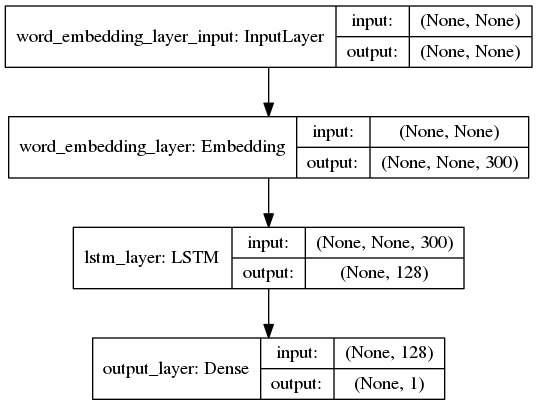

In [0]:
plot_model(model, to_file='basic_lstm_classifier.png', show_layer_names=True, show_shapes=True)
Image('basic_lstm_classifier.png')

<code>Modify the network by adding two more Dense layers with Batch-Normalization and Dropouts:

> Indented block



In [0]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

model.add(Dense(32, name='dense_1'))
# model.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model.add(Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(Activation(activation='relu', name='activation_1'))

model.add(Dense(8, name='dense_2'))
# model.add(BatchNormalization(name='bn_2'))
model.add(Dropout(rate=0.3, name='dropout_2'))
model.add(Activation(activation='relu', name='activation_2'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         5754300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
__________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 22s - loss: 0.5763 - acc: 0.7061 - val_loss: 0.4798 - val_acc: 0.7563
Epoch 2/10
9595/9595 [==============================] - 21s - loss: 0.4929 - acc: 0.7762 - val_loss: 0.4452 - val_acc: 0.7826
Epoch 3/10
9595/9595 [==============================] - 21s - loss: 0.4634 - acc: 0.7917 - val_loss: 0.4570 - val_acc: 0.7854
Epoch 4/10
9595/9595 [==============================] - 21s - loss: 0.4319 - acc: 0.8101 - val_loss: 0.4359 - val_acc: 0.7863
Epoch 5/10
9595/9595 [==============================] - 21s - loss: 0.4054 - acc: 0.8201 - val_loss: 0.4572 - val_acc: 0.7732
Epoch 6/10
9595/9595 [==============================] - 21s - loss: 0.3823 - acc: 0.8351 - val_loss: 0.4475 - val_acc: 0.7948
Epoch 7/10
9595/9595 [==============================] - 21s - loss: 0.3502 - acc: 0.8508 - val_loss: 0.4525 - val_acc: 0.7891
Epoch 8/10
9595/9595 [==============================] - 21s - loss: 0.

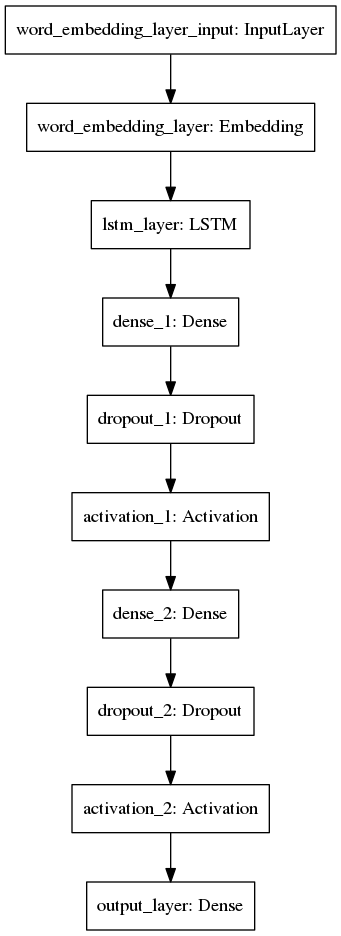

In [0]:
plot_model(model, to_file='modified_lstm_classifier.png', show_layer_names=True)
Image('modified_lstm_classifier.png')